In [228]:
#import pandas as pd
import warnings

import numpy as np
import matplotlib.pyplot as plt
import random
import json
from sklearn.manifold import TSNE
import warnings
import seaborn as sbs

### changelog
- new model with more dimensions
- all classes remade
- in general more interaction with constructor

# Workflow

functions of the different classes:

1. generator:

    generate data sampled from gaussian distribution

    in: parameters

    out: [class, samples, features]
    

2. confounder_injection: confound generated data 

    create bias with different functions (atm "prior shift" can be used)
    
    in: [class, samples, features], parameters
    
    out [class, samples, features]


3. create_dataset:
    
    takes numpy array and parameters to create tensors, datasets and finally dataloaders (for input in pytorch models)

    in: [samples, features], split
    
    out: dataloaders
    

4. run_pytorch:
    
    trains and tests model with given dataloaders and parameters
    
    in: mode, dataloaders
    
    out: mean accuracy and loss
    

5. test_network
    in: params, number of rounds
    
    combines these functions for easier testing

# Plotting

In [229]:
warnings.filterwarnings("ignore",category=FutureWarning)

In [230]:
# plot distributions (includes all samples of the class)
def plot_dist(x, y):
    data = convert_to_3d(x, y)
    size = data.shape[1:]
    
    for c in data:
        c = np.array(c).flatten()
        plt.hist(c, bins=100, density=True)
    plt.title("Distribution of values")
    plt.ylabel("Probability")
    plt.xlabel("Value")
    plt.show()

In [231]:
# plot 2 distributions
def plot_2dist(x, y, x_cf, y_cf):
    data = convert_to_3d(x, y)
    data_cf = convert_to_3d(x_cf, y_cf)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
    fig.suptitle('Comparison of confounded and non-confounded distributions')
    fig.set_figwidth(15)

    # plot original distributions
    for c in data:
        c = np.array(c).flatten()
        ax1.hist(c, bins=100, density=False)
    ax1.set_title("Distribution of values")
    ax1.set(xlabel="Value", ylabel="Number of Samples")

    # plot confounded distributions
    for c in data_cf:
        c = np.array(c).flatten()
        ax2.hist(c, bins=100, density=False)

    ax2.set_title("Distribution of confounded values")
    ax2.set(xlabel="Value", ylabel="Number of Samples")

In [232]:
# plot 2 distributions
def plot_2dist_scatter(x, y, x_cf, y_cf):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False)
    fig.suptitle('Comparison of confounded and non-confounded distributions')
    fig.set_figwidth(15)

    # plot original distributions
    sbs.scatterplot(ax=ax1, x=x[:,0], y=x[:,1], hue=y)
    ax1.set_title("t-SNE")
    ax1.set(xlabel="x", ylabel="y")

    # plot confounded distributions
    sbs.scatterplot(ax=ax2, x=x_cf[:,0], y=x_cf[:,1], hue=y_cf)
    ax2.set_title("t-SNE (confounded)")
    ax2.set(xlabel="x", ylabel="y")

In [233]:
# plot distributions (includes all samples of the class)
def plot_dist_tsne(x, y):

    sbs.scatterplot(x=x[:,0], y=x[:,1], hue=y)
    plt.title("t-SNE")
    plt.ylabel("Probability")
    plt.xlabel("Value")
    plt.show()

In [234]:
# use t-SNE for plotting
def plot_2dist_tsne(x, y, x_cf, y_cf):
    x_embedded = TSNE(random_state=42, n_components=2, learning_rate="auto", init="pca").fit_transform(x)
    x_cf_embedded = TSNE(random_state=42, n_components=2, learning_rate="auto", init="pca").fit_transform(x_cf)
    plot_2dist_scatter(x_embedded, y, x_cf_embedded, y_cf)

In [235]:
def plot_4dist(x, y):
    fig, ax = plt.subplots(2, 2, sharey=False, sharex=False)
    fig.suptitle('Comparison of confounded and non-confounded distributions')
    fig.set_figwidth(15)

    # plot original distributions
    sbs.scatterplot(ax=ax[0][0], x=x[0][:,0], y=x[0][:,1], hue=y[0])
    ax[0][0].set_title("t-SNE")
    ax[0][0].set(xlabel="x", ylabel="y")

    # plot confounded distributions
    sbs.scatterplot(ax=ax[0][1], x=x[1][:,0], y=x[1][:,1], hue=y[1])
    ax[0][1].set_title("t-SNE (confounded)")
    ax[0][1].set(xlabel="x", ylabel="y")

    # plot confounded distributions
    sbs.scatterplot(ax=ax[1][0], x=x[2][:,0], y=x[2][:,1], hue=y[2])
    ax[1][0].set_title("t-SNE (confounded)")
    ax[1][0].set(xlabel="x", ylabel="y")

    # plot confounded distributions
    sbs.scatterplot(ax=ax[1][1], x=x[3][:,0], y=x[3][:,1], hue=y[3])
    ax[1][1].set_title("t-SNE (confounded)")
    ax[1][1].set(xlabel="x", ylabel="y")

In [236]:
def plot_4dist_tsne(x, y):
    x0_embedded = TSNE(random_state=42, n_components=2, learning_rate="auto", init="pca").fit_transform(x[0])
    x1_embedded = TSNE(random_state=42, n_components=2, learning_rate="auto", init="pca").fit_transform(x[1])
    x2_embedded = TSNE(random_state=42, n_components=2, learning_rate="auto", init="pca").fit_transform(x[2])
    x3_embedded = TSNE(random_state=42, n_components=2, learning_rate="auto", init="pca").fit_transform(x[3])
    plot_4dist([x0_embedded,x1_embedded,x2_embedded,x3_embedded], y)


# Generating Data

Generator returns data of dimension (class, samples, features) where the features of the samples are taken from gaussian distributions with adjustable parameters.

In [237]:
class generator:
    def __init__(self, params):
        self.data = None
        self.params = params["generator"]
        self.create_data()
        
    
    
    def create_data(self):
        '''
        creates the test data with the distributions given by the parameters
        '''
        
        data = []
        
        for c in self.params["gauss"]:
            clas = []
            for n in range(0, self.params["sample_number"]):
                sample = []
                for mean, std in self.params["gauss"][c]:
                    sample.extend(np.random.normal(mean, std, 1))
                clas.append(sample)
            data.append(clas)
                                
        self.data = np.array(data)
        
        return
    
        
    def get_data(self):
        '''
        dimension of data is (class, sample, feature)
        '''
        
        return self.data
    

convert_to_3d takes x of dimension (samples, features) and y of dimension (samples) and outputs array of dimension (class, samples, features)

In [238]:
def convert_to_3d(x, y):
    classes = np.unique(y)
    array = []
    
    for c in classes:
        filter_array = (y == c)
        
        array.append(x[filter_array].tolist())
    
    return np.array(array)
    

convert_to_2d takes data of dimension (class, samples, features) and outputs arrays x of dimension (samples, features) and y of dimension (samples)

In [239]:
def convert_to_2d(x):
    new_x = np.reshape(x,(x.shape[0]*x.shape[1], x.shape[2]))
    new_y = []
    
    for i in range(0,len(x)):
        for j in x[i]:
            new_y.append(i)
    new_y = np.array(new_y)
    
    return new_x, new_y

Can be used to shuffle the data before creating datasets (and dataloaders) from it. Since the data is ordered by class there might be problems without shuffling

In [240]:
def shuffle_2d_array(x, y):
    assert len(x) == len(y)
    p = np.random.RandomState(seed=42).permutation(len(x))
    return x[p], y[p]

Use functions to generate data and plot these

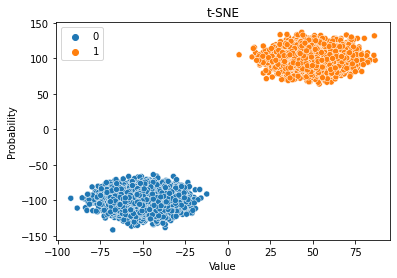

In [241]:
params = {
    "generator":{
        "sample_number": 10000,
        "gauss":{
            "class_0": [(-50,10),(-100,10), (-200, 50)],
            "class_1": [(50,10),(100,10), (0, 50)]
        }
    }
}

g = generator(params)


data = g.get_data()
x, y = convert_to_2d(data)
plot_dist_tsne(x, y)

# Confounder Injection

### Definition of Confounder Class

The confounder class can be used to inject confounders in data given as numpy arrays (class, samples, features) and outputs numpy arrays of the same dimension

In [242]:
class confounder_injection:
    def __init__(self, data, params):
        self.data = np.array(data)
        self.params = params
        
        if "inject_noise" in self.params["confounding"]:
            self.inject_noise()
        if "add_confounder" in self.params["confounding"]:
            self.add_confounder()
        # TODO should parse the parameters and execute confounding techniques which are specified in the params
    
    
    def inject_noise(self):
        '''
        Injects noise in distribution
        Parameters are noise_rate (number of samples to be manipulated) and noise_factor (impact of noise)
        '''
        noise_params = self.params["confounding"]["inject_noise"]
        
        for noise in noise_params:
            noise_rate = noise_params[noise]["noise_rate"]
            noise_factor = noise_params[noise]["noise_factor"]
            for c in noise_params[noise]["classes"]:
                for i in range(0,len(self.data[c])):
                    if random.uniform(0, 1) < noise_rate:
                        self.data[c][i] += random.uniform(-noise_factor,noise_factor)

        return
    
    
    def add_confounder(self):
        '''
        Injects confounder in distribution
        Parameters are distribution, mean  and std
        '''
        add_confounder_params = self.params["confounding"]["add_confounder"]
        
        for c in add_confounder_params:
            confounder = add_confounder_params[c]

            distribution = None
            if confounder["distribution"] == "gauss":
                distribution = np.random.normal
            assert distribution != None
            
            for c in confounder["classes"]:
                for i in range(0,len(self.data[c])):
                    for f in confounder["features"]:
                        self.data[c][i][f] += distribution(confounder["mean"], confounder["std"])
        
        return
        
        
    def get_data(self):
        return self.data

# Pytorch Model

In [243]:
import torch
from torch import nn
from torch.utils.data import DataLoader
#from torchvision import datasets
#from torchvision.transforms import ToTensor, Lambda, Compose

### Custom Dataset for Pytorch

In [244]:
class CfDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


### Conversion of numpy arrays to dataloaders

Pytorch needs dataloaders as inputs. This class handels conversion from output from confounder class (numpy array), to tensor, datasets and finally dataloaders. Furthermore the data is split into training- and test-data

In [245]:
class create_dataset:
    def __init__(self, x, y, split):
        self.x = x
        self.y = y
        self.split = split

    
    def get_dataset(self):
        # not needed anymore
        #x, y = transform_array(x,  y)

        tensor_x = torch.Tensor(self.x)
        tensor_y = torch.Tensor(self.y).long()

        dataset = CfDataset(tensor_x, tensor_y)
        return dataset


    def split_dataset(self, dataset):
        # split dataset
        train_size = int(self.split * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])
        return train_dataset, test_dataset

    # returns dataloader for NN
    def get_dataloader(self):
        dataset = self.get_dataset()
        train_dataset, test_dataset = self.split_dataset(dataset)

        # create DataLoader
        train_dataloader = DataLoader(train_dataset, shuffle=True)
        test_dataloader = DataLoader(test_dataset, shuffle=True)

        return train_dataloader, test_dataloader

### NNs for computations

NeuralNetwork is basically a linear classifier

In [246]:
# Building a Neural Network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 2),
            #nn.ReLU(),
            #nn.Linear(100, 2),
            #nn.ReLU(),
            #nn.Linear(8, 3)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Train and test model with pytorch

Defines train- and test-methods and runs these on the model with the input data

In [247]:
class run_pytorch:
    def __init__(self, model, train_dataloader, test_dataloader, input_size):
        if model == "NeuralNetwork()":
            self.model = NeuralNetwork(input_size)
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        #self.run()

    
    # Training
    def train(self, dataloader, loss_fn, optimizer, device):
        size = len(dataloader.dataset)
        self.model.train()
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            # Compute prediction error
            pred = self.model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
    # Defining the test
    def test(self, dataloader, loss_fn, device):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        self.model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X,y in dataloader:
                X,y = X.to(device), y.to(device)
                pred = self.model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size

        return correct, test_loss
    
    
    def run(self):

        # Defining model
        device = "cpu"
        self.model = self.model.to(device)

        # Defining loss function and optimizer
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-3)

        epochs = 1
        mean = 0
        loss = 0

        for t in range(epochs):
            #print(f"Epoch {t+1}\n-------------------------------")
            self.train(self.train_dataloader, loss_fn, optimizer, device)
            correct, test_loss = self.test(self.test_dataloader, loss_fn, device)
            mean +=correct
            loss += test_loss
        #print("Done!\n\n")

        return mean/epochs, loss/epochs
    

# Check for confounders

test_network combines the functions from before and allows easy testing.
Premade functions for specific data shifts are available which can be called without needing to know how the generator class, confounder_injection class, etc. work

In [248]:
class test_network:
    def __init__(self, params, i):
        self.model = params["model"]
        self.params = params
        self.x = None
        self.y = None
        self.x_cf = None
        self.y_cf = None
        self.i = i
    
    
    def compute_for_i_rounds(self):

        mean, loss, mean_cf, loss_cf = 0, 0, 0, 0

        for k in range(0, self.i):

            #classes needed for computation
            dataset = create_dataset(self.x, self.y, split=0.8)
            dataset_cf = create_dataset(self.x_cf, self.y_cf, split=0.8)

            # run model on non-confounded class
            train_dataloader, test_dataloader = dataset.get_dataloader()
            run_pt = run_pytorch(self.model, train_dataloader, test_dataloader, len(self.x[0]))
            ret = run_pt.run()
            
            mean += ret[0]
            loss += ret[0]

            # run model on non-confounded class     
            train_dataloader_cf, test_dataloader_cf = dataset_cf.get_dataloader()
            run_pt_cf = run_pytorch(self.model, train_dataloader_cf, test_dataloader, len(self.x_cf[0]))
            ret_cf = run_pt_cf.run()
            
            mean_cf += ret_cf[0]
            loss_cf += ret_cf[0]

        # compute averages
        mean /= self.i
        loss /= self.i
        mean_cf /= self.i
        loss_cf/= self.i

        print(f"---- Computation was done for {self.i} rounds ----")
        print(f"Non-confounded dataset achieved accuracy of: {mean*100}% and average loss of {loss}")
        print(f"Confounded dataset achieved accuracy of: {mean_cf*100}% and average loss of {loss_cf}")

        
    def run(self):
        # generate data
        g = generator(self.params)
        data = g.get_data()
        self.x, self.y = convert_to_2d(data)
        self.x, self.y = shuffle_2d_array(self.x, self.y)
                
        # add bias
        cf = confounder_injection(data, self.params)
        data_cf = cf.get_data()
        self.x_cf, self.y_cf = convert_to_2d(data_cf)
        self.x_cf, self.y_cf = shuffle_2d_array(self.x_cf, self.y_cf)
        
        # plot
        #plot_2dist_tsne(self.x, self.y, self.x_cf, self.y_cf)
        plot_4dist_tsne([self.x, self.x, self.x_cf, self.x_cf],[self.y, self.y, self.y_cf, self.y_cf])
        
        # compute 
        self.compute_for_i_rounds()
        
        return

### Run tests

Parameter combinations can be stored in the dictionary

In [249]:
with open("parameters.json") as file:
    parameters = json.load(file)

With the test_network class it's easy to test new combinations parameters

---- Computation was done for 1 rounds ----
Non-confounded dataset achieved accuracy of: 100.0% and average loss of 1.0
Confounded dataset achieved accuracy of: 100.0% and average loss of 1.0


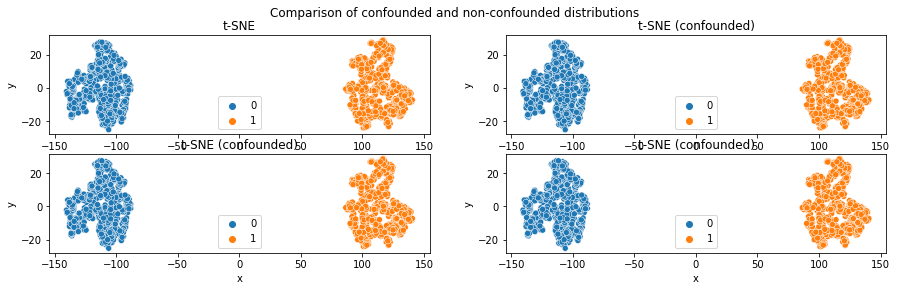

In [250]:
tn = test_network(parameters["2features_justNoise_easy"], i=1)
tn.run()

---- Computation was done for 1 rounds ----
Non-confounded dataset achieved accuracy of: 100.0% and average loss of 1.0
Confounded dataset achieved accuracy of: 85.25% and average loss of 0.8525


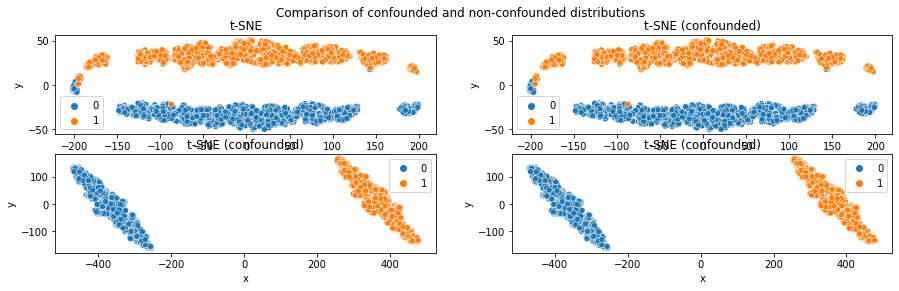

In [251]:
tn = test_network(parameters["add_confounder_1"], i=1)
tn.run()

In [252]:
# tn = test_network(parameters["param_2"], i=1)
# tn.run()

In [253]:
# tn = test_network(parameters["param_3"], i=1)
# tn.run()